Vocabulary size: 4666
Dataset size: 45229
Epoch 1/20, Loss: 6.4479, Accuracy: 0.0852
Epoch 2/20, Loss: 5.6177, Accuracy: 0.1230
Epoch 3/20, Loss: 5.0855, Accuracy: 0.1485
Epoch 4/20, Loss: 4.5961, Accuracy: 0.1759
Epoch 5/20, Loss: 4.1143, Accuracy: 0.2091
Epoch 6/20, Loss: 3.6343, Accuracy: 0.2582
Epoch 7/20, Loss: 3.1698, Accuracy: 0.3262
Epoch 8/20, Loss: 2.7337, Accuracy: 0.4090
Epoch 9/20, Loss: 2.3313, Accuracy: 0.4945
Epoch 10/20, Loss: 1.9648, Accuracy: 0.5796
Epoch 11/20, Loss: 1.6344, Accuracy: 0.6636
Epoch 12/20, Loss: 1.3412, Accuracy: 0.7354
Epoch 13/20, Loss: 1.0852, Accuracy: 0.8028
Epoch 14/20, Loss: 0.8623, Accuracy: 0.8575
Epoch 15/20, Loss: 0.6765, Accuracy: 0.9004
Epoch 16/20, Loss: 0.5221, Accuracy: 0.9359
Epoch 17/20, Loss: 0.3980, Accuracy: 0.9594
Epoch 18/20, Loss: 0.3012, Accuracy: 0.9741
Epoch 19/20, Loss: 0.2282, Accuracy: 0.9835
Epoch 20/20, Loss: 0.1752, Accuracy: 0.9880

Generated Text:
dorothy looked at the animal youre dreadfully skinny oh well im old sa

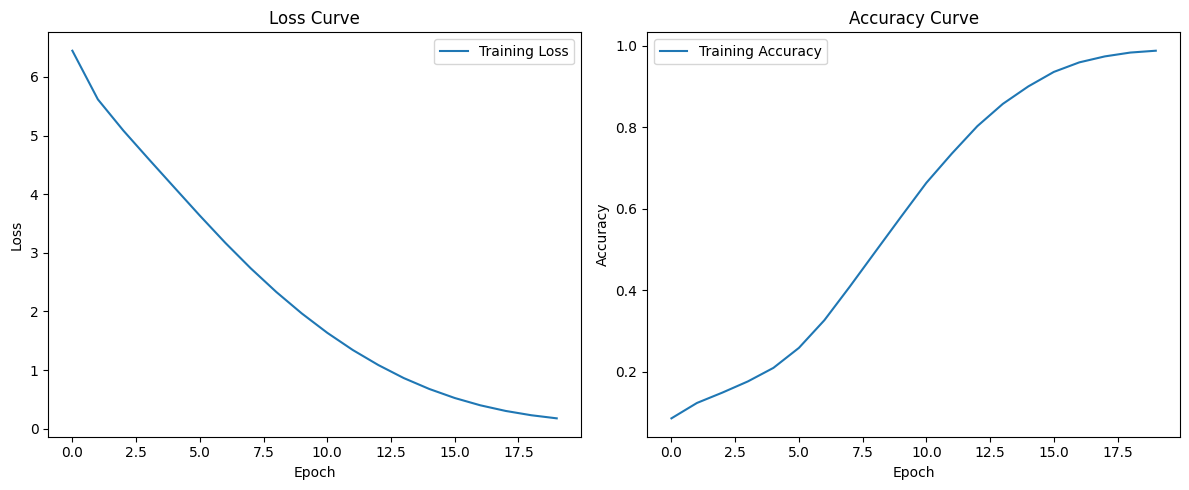

In [ ]:
# Import Required Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import re
import matplotlib.pyplot as plt

#  Load the dataset
file_path = "wizard_of_oz.txt"
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the file path.")
    exit()
# Preprocessing
# Clean text: remove special characters, lowercase, and tokenize
text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
text = text.lower()                      # Convert to lowercase
words = text.split()                     # Tokenize using whitespace

# Define Custom Dataset for LLM
class TextDataset(Dataset):
    def __init__(self, tokens, seq_length):
        self.seq_length = seq_length
        self.tokens = tokens
        self.vocab = list(set(self.tokens))  # Unique words
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.data = [self.tokens[i:i + seq_length + 1] for i in range(len(self.tokens) - seq_length)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        inputs = [self.word_to_idx[word] for word in sample[:-1]]
        target = self.word_to_idx[sample[-1]]
        return torch.tensor(inputs), torch.tensor(target)

# Define sequence length
seq_length = 5
dataset = TextDataset(words, seq_length)

# DataLoader for batching
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(f"Vocabulary size: {len(dataset.vocab)}")
print(f"Dataset size: {len(dataset)}")

# Define Simple LSTM-based LLM
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Predict the next word based on the last hidden state
        return out

# Model parameters
vocab_size = len(dataset.vocab)
embed_size = 128
hidden_size = 256

# Initialize model, loss function, and optimizer
model = LSTMModel(vocab_size, embed_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the LLM with Accuracy Calculation
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update loss
        total_loss += loss.item()

        # Calculate accuracy
        predictions = torch.argmax(outputs, dim=1)
        correct_predictions += (predictions == targets).sum().item()
        total_samples += targets.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Generate Text using the Trained Model
def generate_text(model, dataset, start_text, num_words=20):
    model.eval()
    words = start_text.split()
    for _ in range(num_words):
        # Convert the last `seq_length` words to indices
        input_seq = torch.tensor([[dataset.word_to_idx[word] for word in words[-seq_length:]]])
        with torch.no_grad():
            output = model(input_seq)
            next_word_idx = torch.argmax(output, dim=1).item()
            words.append(dataset.idx_to_word[next_word_idx])
    return " ".join(words)

# Example: Generate text starting with a seed phrase
seed_text = "dorothy looked"
generated_text = generate_text(model, dataset, seed_text)
print("\nGenerated Text:")
print(generated_text)

# Plot Learning Curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model, "trained_llm.pth")


In [ ]:
# Extract unique words from the text
vocab = list(set(words))  # `words` is the tokenized text


In [ ]:
with open("vocab.txt", "w") as f:
    for word in vocab:
        f.write(word + "\n")
